#### Copyright (c) 2023 Dan Brennan/University of Sheffield

# Graph Comparisons using Maximum Common Subgraph/Jaccard Index

This is code is for the generation of DCE 2023 JP. The paper details are:

> Daniel S. Brennan, Timothy J. Rogers, Elizabeth J. Cross, Keith Worden.  * Calculating structural similarity in Population-based Structural Health Monitoring* Data Centric Engineering 2023.

If you use this code, please cite the above paper.

The goal of this notebook is to take the same datasets that have been used within the GMN papers previous (below) and compare the results and possible scenarios in which each algorithm has the most beneficial scenario for use.

Introducing Graph Matching Networks and the Canonical Form for IE models:

> Daniel S. Brennan, Timothy J. Rogers, Elizabeth J. Cross, Keith Worden.  * Calculating structure similarity via a Graph Neural Network in Population-based Structural Health Monitoring* ISMA 2022.

Embedding element attributes as nodes:

> Daniel S. Brennan, Timothy J. Rogers, Elizabeth J. Cross, Keith Worden.  * Calculating structure similarity via a Graph Neural Network in Population-based Structural Health Monitoring: Part II* IMAC-XLI.

## Dependencies
The code below relies upon some standard libraries as well as the backtracking algorithm implemented by Dr Julian Gosliga (https://github.com/jgosliga)

To install the dependencies within a new virtual environment:
```
pip install -r requirements.txt
```

Note: the code was tested and built upon python 3.7.6

In [1]:
# Libraries for AttributedGraphDataset
import numpy as np
import os.path
import os
import json
import sys
import re
# Libraries for Graph Matching
import algorithm.backtracking as bt
# Libraries for Outputs
import matplotlib.pyplot as plt

## Class to handle datasets
For the GMN, a AttributedGraphDataset class was created to load our learning dataset (https://github.com/dsbrennan/ie-model-learning-data) into the GMN algorithm and package the IE models into graphs that the GMN code would understand. 

For the Graph Comparison, we have created a new AttributedGraphDataset class, but used the same method names where appropriate. The static factory method pattern of load_dataset is also used, taking a learning dataset and the canonical form datsset and returns an instantiated AttributedGraphDataset's for training, validation and test sets.

In [2]:
class AttributedGraphDataset:
    """Attributed Graph Dataset"""

    def __init__(self):
        """Constructor
        
        Initialises populations, graphs, labels and pairs storage lists
        """
        # Graph Data Storage
        self._ids = []
        self._populations = []
        self._graphs = []
        # Pair Data Storage
        self._names = []
        self._pairs = []

    def add_graph(self, id: str, population: str, graph: object):
        """Add Graph to Dataset

        'id': graph name
        'population': string of which population the corresponding graph belongs to
        'graph': a networkx graph representation of the IE model
        """
        # Generate Pairs & Append
        for i in range(0, len(self._graphs)):
            # Add G1 -> G2 paid
            self._names.append((id, self._ids[i]))
            self._pairs.append((graph, self._graphs[i]))
        self._names.append((id, id))
        self._pairs.append((graph, graph))
        # Add Storage
        self._ids.append(id)
        self._populations.append(population)
        self._graphs.append(graph)

    @staticmethod
    def _generate_graph(elements: list, relationships: list):
        """Generate networkx graph representation of an IE model
        
        'elements': a list of IE model elements
        'relationships': a list of IE model relationships
        return: attributed graph with graph, attributes and count
        """
        # Add Nodes
        graph = {}
        attributes = {}
        for node in elements:
            graph[node["name"]] = []
            attributes[node["name"]] = node["contextual"]["type"] if "contextual" in node else "N/A"
        # Add Edges (Needs to be a N -> N loop to handle relationships with 2+ elements)
        for edge in relationships:
            for node_1 in edge["elements"]:
                for node_2 in edge["elements"]:
                    if node_1["name"] != node_2["name"]:
                        graph[node_1["name"]].append(node_2["name"])
        return {"graph": graph, "attributes": attributes, "count": {"elements": len(elements), "relationships": len(relationships)}}

    @staticmethod
    def load_dataset(folder: str, matching_dataset: str, population_regex: str, validation_percentage: float, test_size: int):
        """Load Dataset

        Generates Training and Validation AttributedGraphDataset's from dataset
        
        'folder': a string of the base directory to find the dataset within
        'matching_dataset': the name of the matching dataset to load
        'population_regex': the regex needed to identify the population from the IE model name
        'validation_percentage': validation/training percentage
        'test_size': test size
        return: (Training Data Set, Validation Data Set, Test Data Set)
        """
        print(f"Loading Matching Dataset: {matching_dataset}")
        # Load Dataset
        if not os.path.isdir(os.path.join(folder, matching_dataset)):
            raise ValueError(f"{os.path.join(folder, matching_dataset)} does not exist")
            sys.exit()
        data = []
        for item in os.listdir(os.path.join(folder, matching_dataset)):
            if not os.path.isfile(os.path.join(folder, matching_dataset, item)):
                continue
            elif item.rfind(".json") == (len(item) - 5):
                with open(os.path.join(folder, matching_dataset, item)) as fs:
                    payload = json.loads(fs.read())
                    population = re.search(rf"{population_regex}", payload["name"])
                    graph = AttributedGraphDataset._generate_graph(payload["models"]["irreducibleElement"]["elements"], payload["models"]["irreducibleElement"]["relationships"])
                    data.append({"id": payload["name"], "population": population.group(), "graph": graph})
        print(f"Total number of Matching datapoints: {len(data)}")
        # Calculate Split for Training, Validation & Test
        np.random.shuffle(data)
        dataset_size = len(data)
        test_split = test_size
        validation_split = dataset_size - int(dataset_size * ((100.0 - validation_percentage) / 100.0))
        training_split = dataset_size - validation_split - test_split
        # Create datasets
        training_set = AttributedGraphDataset()
        training_set_metrics = {}
        for i in range(0, training_split):
            training_set.add_graph(data[i]["id"], data[i]["population"], data[i]["graph"])
            training_set_metrics[data[i]["population"]] = 1 if data[i]["population"] not in training_set_metrics else training_set_metrics[data[i]["population"]] + 1
        validation_set = AttributedGraphDataset()
        validation_set_metrics = {}
        for i in range(training_split, training_split + validation_split):
            validation_set.add_graph(data[i]["id"], data[i]["population"], data[i]["graph"])
            validation_set_metrics[data[i]["population"]] = 1 if data[i]["population"] not in validation_set_metrics else validation_set_metrics[data[i]["population"]] + 1
        test_set = AttributedGraphDataset()
        test_set_metrics = {}
        for i in range(training_split + validation_split, training_split + validation_split + test_split):
            test_set.add_graph(data[i]["id"], data[i]["population"], data[i]["graph"])
            test_set_metrics[data[i]["population"]] = 1 if data[i]["population"] not in test_set_metrics else test_set_metrics[data[i]["population"]] + 1
        # Output Diagnostics
        print(f"Training Set Size: {len(training_set._pairs)} ({len(training_set._ids)} individual graphs)")
        print(*[f"\tPopulation: {metric} Count: {training_set_metrics[metric]}" for metric in training_set_metrics], sep="\r\n")
        print(f"Validation Set Size: {len(validation_set._pairs)} ({len(validation_set._ids)} individual graphs)")
        print(*[f"\tPopulation: {metric} Count: {validation_set_metrics[metric]}" for metric in validation_set_metrics], sep="\r\n")
        print(f"Test Set Size: {len(test_set._pairs)} ({len(test_set._ids)} individual graphs)")
        print(*[f"\tPopulation: {metric} Count: {test_set_metrics[metric]}" for metric in test_set_metrics], sep="\r\n")

        return training_set, validation_set, test_set

## Load datasets
Load the learning matching dataset and canonical form dataset.

In [3]:
# Set Seed for documenation
np.random.seed(7)
# Generate Training, Validation & Test datasets from matching and canoncial datasets
training_set, validation_set, test_set = AttributedGraphDataset.load_dataset(
    folder="/home/danbrennan/Code/ie-model-learning-data/data",
    matching_dataset="learning-slab-bridge-500-span-1-9-column-1-1-node-1-3",
    population_regex="[0-9]+-span",
    validation_percentage=1.0,
    test_size=40
)

Loading Matching Dataset: learning-slab-bridge-500-span-1-9-column-1-1-node-1-3
Total number of Matching datapoints: 4500
Training Set Size: 9748320 (4415 individual graphs)
	Population: 8-span Count: 492
	Population: 5-span Count: 489
	Population: 1-span Count: 487
	Population: 9-span Count: 492
	Population: 7-span Count: 495
	Population: 4-span Count: 491
	Population: 2-span Count: 486
	Population: 3-span Count: 491
	Population: 6-span Count: 492
Validation Set Size: 1035 (45 individual graphs)
	Population: 1-span Count: 9
	Population: 7-span Count: 3
	Population: 3-span Count: 3
	Population: 5-span Count: 8
	Population: 4-span Count: 5
	Population: 2-span Count: 7
	Population: 8-span Count: 2
	Population: 6-span Count: 4
	Population: 9-span Count: 4
Test Set Size: 820 (40 individual graphs)
	Population: 4-span Count: 4
	Population: 8-span Count: 6
	Population: 9-span Count: 4
	Population: 2-span Count: 7
	Population: 3-span Count: 6
	Population: 1-span Count: 4
	Population: 6-span C

## Perform Graph Comparisons
Iterate through the pairs of comparisons within the test dataset (the same which is used within the GMN) and perform the backtracking algorithm against the pair.
Calculate the Jaccard Index for each pair and the maximum common subgraph

In [4]:
number_of_pairs = len(test_set._pairs)
paired_similarity_metrics = []
paired_maximum_common_subgraphs = []
for index, (graph_1, graph_2) in enumerate(test_set._pairs):
    print(f"Matching Pair {index}/{number_of_pairs}: {test_set._names[index][0]} and {test_set._names[index][1]}")
    # Largest graph must be the first parameter
    diagnostic_filename = f"{index}-{test_set._names[index][0]}-{test_set._names[index][1]}.json"
    backtrack_results = bt.backtrack(graph_2, graph_1, filename=diagnostic_filename) if graph_1["count"]["elements"] < graph_2["count"]["elements"] else bt.backtrack(graph_1, graph_2, filename=diagnostic_filename)
    ## Maximum Common Subgraph
    maximum_common_subgraphs = []
    for result in backtrack_results:
        if len(maximum_common_subgraphs) == 0 or len(result) > len(maximum_common_subgraphs[0]):
            maximum_common_subgraphs = [result]
        elif len(result) == len(maximum_common_subgraphs[0]):
            maximum_common_subgraphs.append(result)
    paired_maximum_common_subgraphs.append(maximum_common_subgraphs)
    ## Jaccard Index
    jaccard_index = len(maximum_common_subgraphs[0]) / (graph_1["count"]["elements"] + graph_2["count"]["elements"] - len(maximum_common_subgraphs[0]))
    paired_similarity_metrics.append(jaccard_index)

Matching Pair 0/820: slab-bridge-73-4-span-1-columns and slab-bridge-73-4-span-1-columns
Matching Pair 1/820: slab-bridge-334-8-span-1-columns and slab-bridge-73-4-span-1-columns
Matching Pair 2/820: slab-bridge-334-8-span-1-columns and slab-bridge-334-8-span-1-columns
Matching Pair 3/820: slab-bridge-319-9-span-1-columns and slab-bridge-73-4-span-1-columns
Matching Pair 4/820: slab-bridge-319-9-span-1-columns and slab-bridge-334-8-span-1-columns
Matching Pair 5/820: slab-bridge-319-9-span-1-columns and slab-bridge-319-9-span-1-columns
Matching Pair 6/820: slab-bridge-202-4-span-1-columns and slab-bridge-73-4-span-1-columns
Matching Pair 7/820: slab-bridge-202-4-span-1-columns and slab-bridge-334-8-span-1-columns
Matching Pair 8/820: slab-bridge-202-4-span-1-columns and slab-bridge-319-9-span-1-columns
Matching Pair 9/820: slab-bridge-202-4-span-1-columns and slab-bridge-202-4-span-1-columns
Matching Pair 10/820: slab-bridge-286-2-span-1-columns and slab-bridge-73-4-span-1-columns
Matc

## Outputs
Create a sorted similarity matrix from the Jaccard index scores

In [5]:
# Order Bridge IDs
sorted_population_list = sorted(list(dict.fromkeys(test_set._populations)))
sorted_id_list = []
for population in sorted_population_list:
    id_list = []
    for i in range(0, len(test_set._populations)):
        if test_set._populations[i] != population:
            continue
        id_list.append(test_set._ids[i])
    sorted_id_list.extend(sorted(id_list))

# Similarity Matrix
id_similarity_matrix = np.zeros((len(sorted_id_list), len(sorted_id_list)))
for i in range(0, len(paired_similarity_metrics)):
    id_similarity_matrix[sorted_id_list.index(test_set._names[i][0])][sorted_id_list.index(test_set._names[i][1])] = paired_similarity_metrics[i]
    id_similarity_matrix[sorted_id_list.index(test_set._names[i][1])][sorted_id_list.index(test_set._names[i][0])] = paired_similarity_metrics[i]

# Generate Friendly Names
sorted_id_friendly_list = []
for i in range(0, len(sorted_id_list)):
    match = re.search(rf"[0-9]+-[0-9]+-span", sorted_id_list[i])
    parts = match.group().split("-")
    sorted_id_friendly_list.append("{0} (#{1})".format(parts[1], parts[0]))

Display a heatmap for all of the test set results

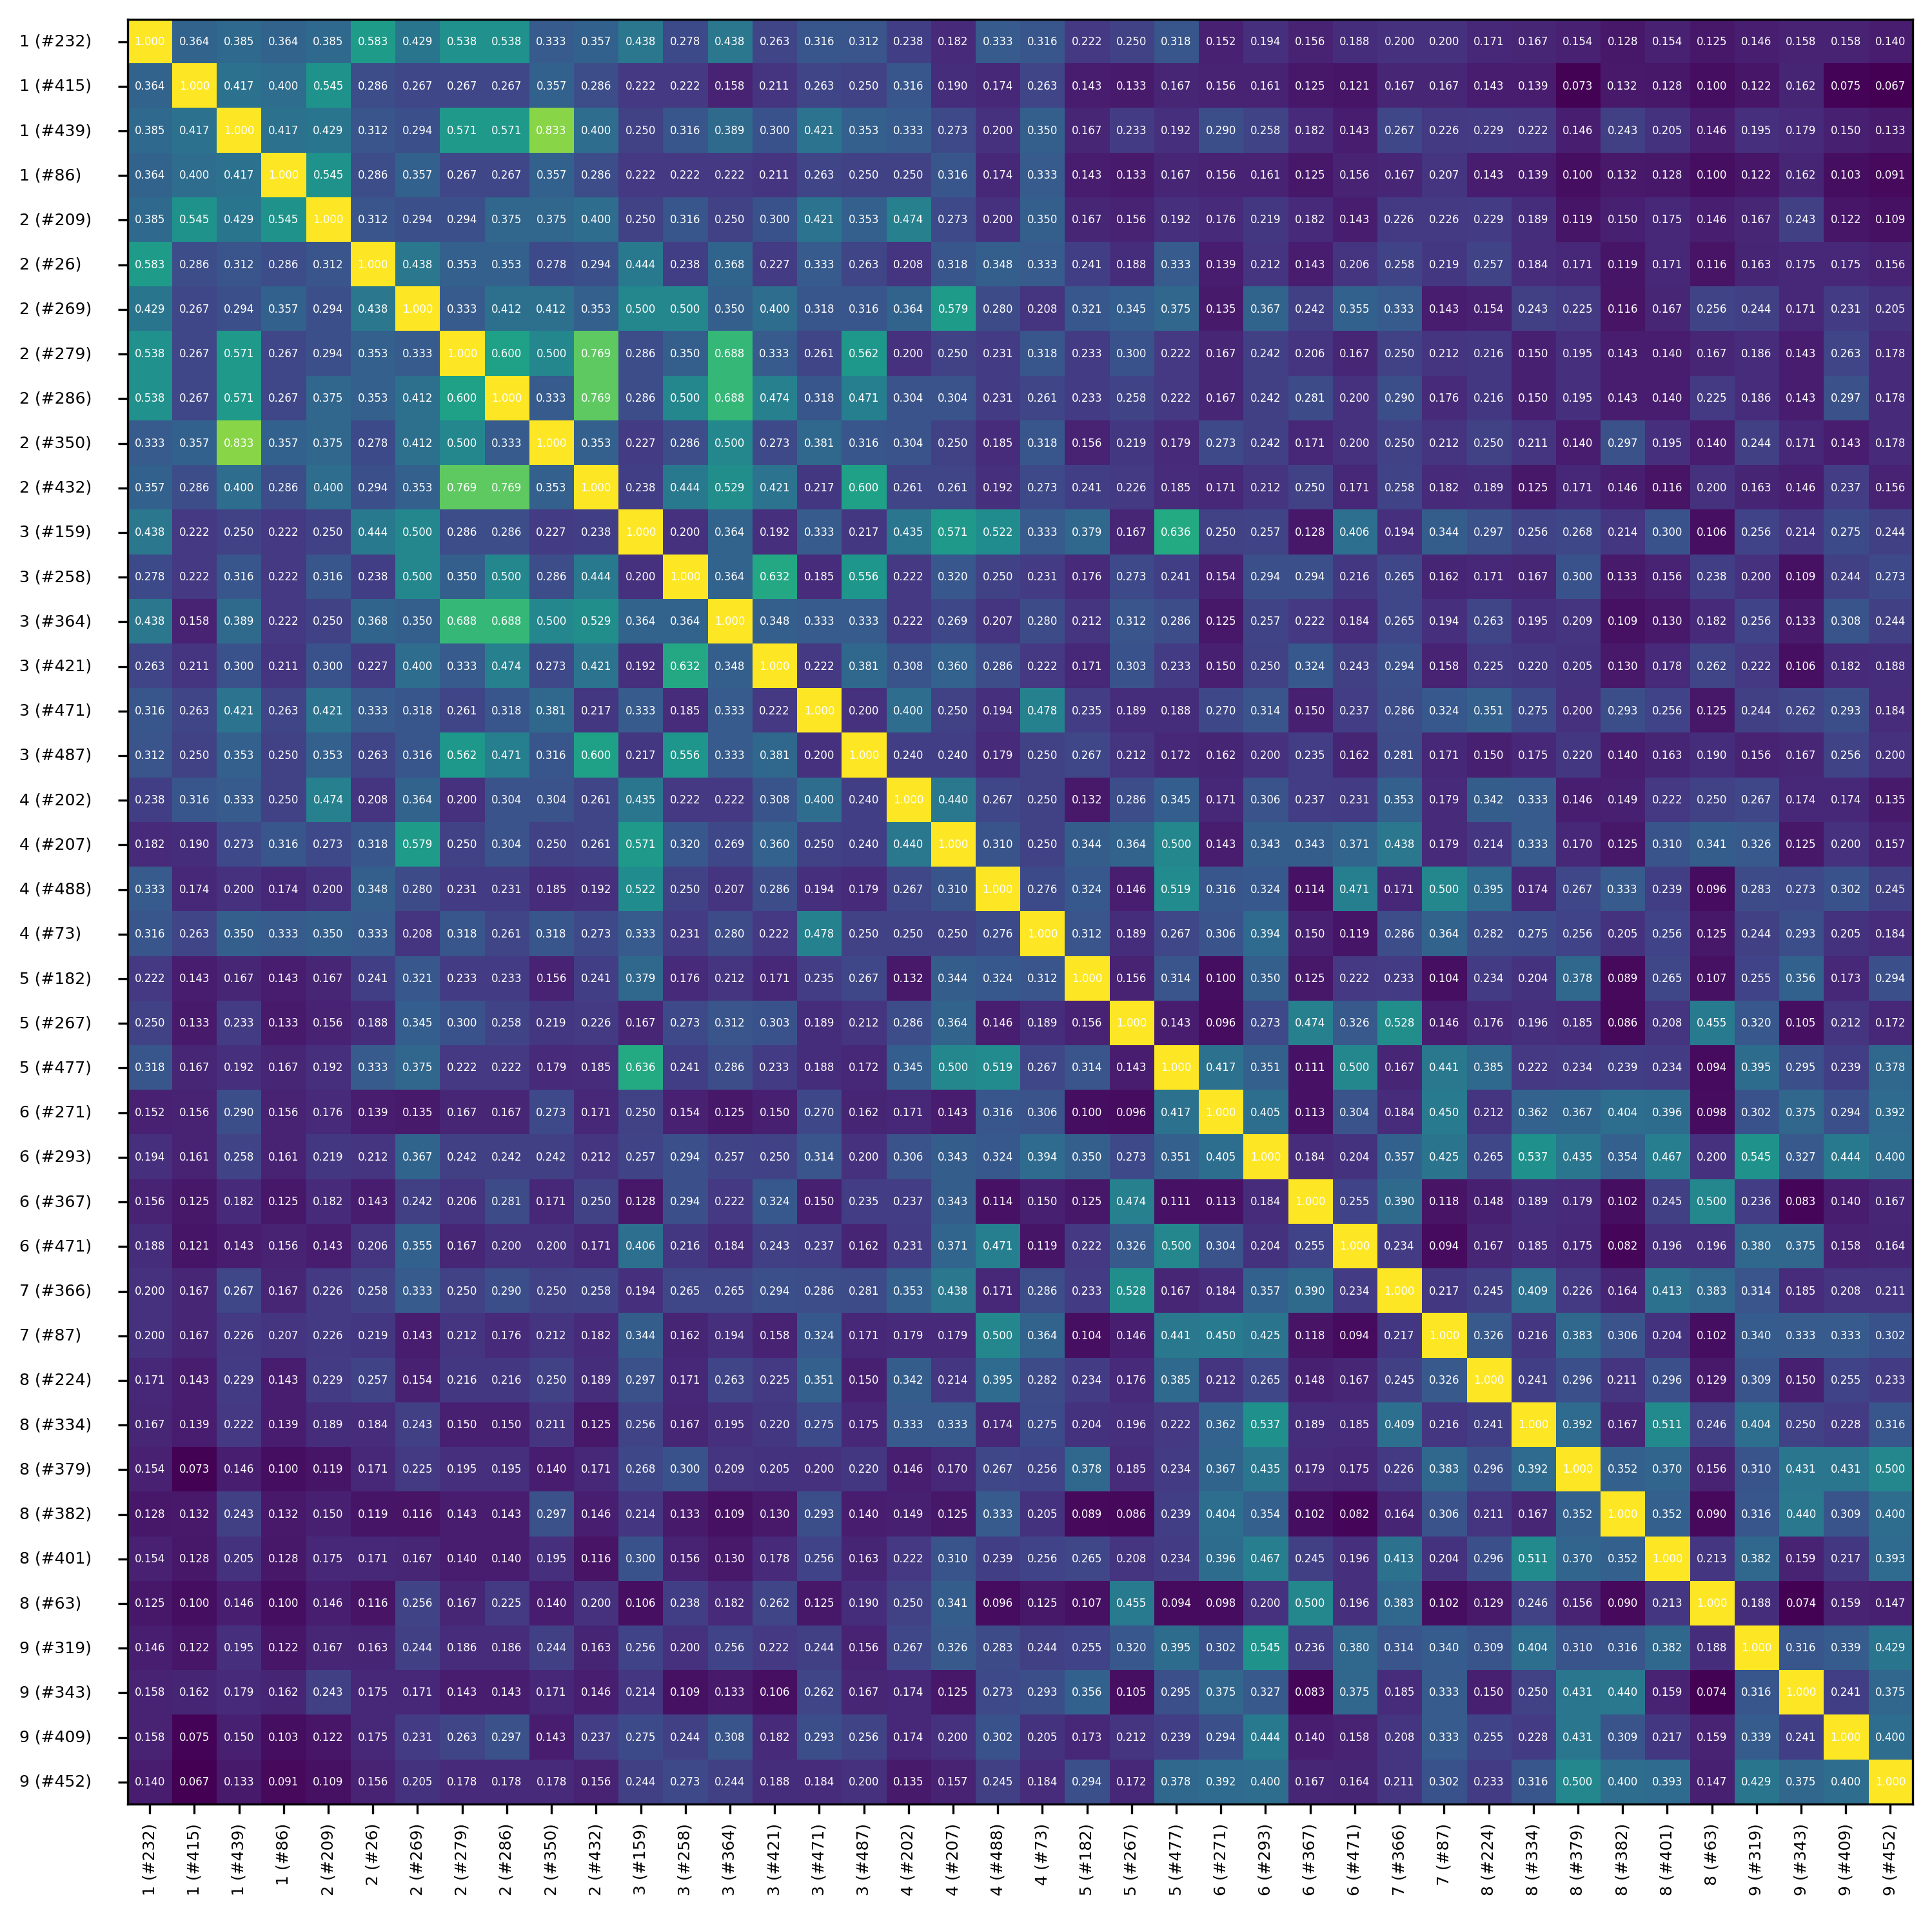

In [6]:
#Display Heat Map
fig, ax = plt.subplots(figsize=(15,10), dpi=300)
im = ax.imshow(id_similarity_matrix)

ax.set_xticks(np.arange(len(test_set._ids)), labels=sorted_id_friendly_list, fontsize="6", rotation=90)
ax.set_yticks(np.arange(len(test_set._ids)), labels=sorted_id_friendly_list, ha="left", va="center", position=(-0.05, 0), fontsize="6")

for i in range(len(sorted_id_list)):
    for j in range(len(sorted_id_list)):
        text = ax.text(j, i, "{:.3f}".format(id_similarity_matrix[i, j]), ha="center", va="center", color="w", fontsize="4")

# fig.colorbar(im)
fig.tight_layout()
plt.show()

### Paper Outputs 
Create a reduced set of results of 1 structure per population for display within the paper

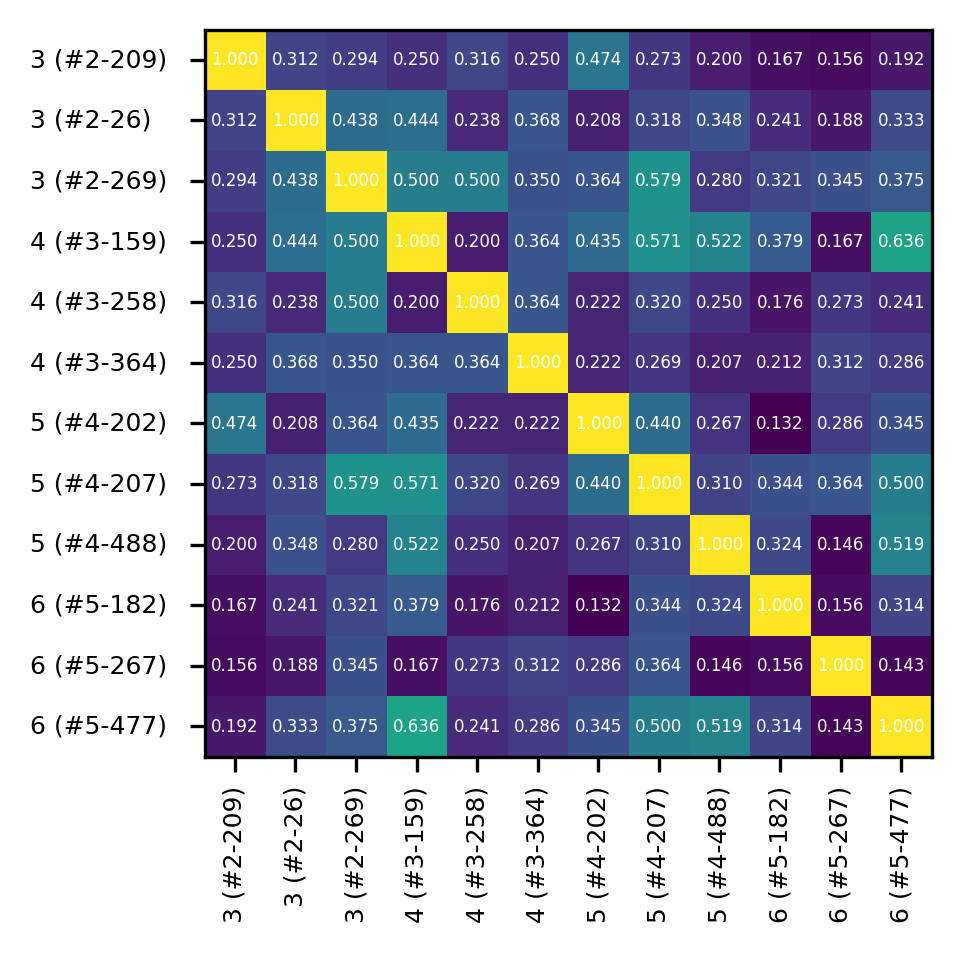

In [7]:
# Output Settings
desired_inputs_per_population = 3
desired_population_filter = [2, 5]

# Get the desired input
desired_inputs = {}
desired_populations = []
for i,input in enumerate(sorted_id_friendly_list):
    parts = input.split(" ")
    if int(parts[0]) < desired_population_filter[0] or int(parts[0]) > desired_population_filter[1]:
        continue
    if desired_populations.count(parts[0]) < desired_inputs_per_population:
        desired_inputs[input] = i
        desired_populations.append(parts[0])

#Get Matrix
desired_id_matrix = np.zeros((len(desired_inputs), len(desired_inputs)))
for i, left_key in enumerate(desired_inputs):
    for j, right_key in enumerate(desired_inputs):
        desired_id_matrix[i, j] = id_similarity_matrix[desired_inputs[left_key], desired_inputs[right_key]]

#Generate Display Names
desired_display_names = []
for key in desired_inputs:
    search = re.search("([0-9]) \(#([0-9]+)\)", key)
    desired_display_names.append(f"{int(search.groups()[0]) + 1} (#{search.groups()[0]}-{search.groups()[1]})")

#Display Heat Map
fig, ax = plt.subplots(figsize=(0.277 * len(desired_inputs), 0.277 * len(desired_inputs)), dpi=300)
im = ax.imshow(desired_id_matrix)

ax.set_xticks(np.arange(len(desired_inputs)), labels=desired_display_names, fontsize="6", rotation=90)
ax.set_yticks(np.arange(len(desired_inputs)), labels=desired_display_names, ha="left", va="center", position=(-0.2, 0), fontsize="6")

for i in range(len(desired_inputs)):
    for j in range(len(desired_inputs)):
        text = ax.text(j, i, "{:.3f}".format(desired_id_matrix[i, j]), ha="center", va="center", color="w", fontsize="4")

# fig.colorbar(im)
fig.tight_layout()
plt.show()